# Bayesian Multilevel Modelling using PyStan

This is a tutorial, following through Chris Fonnesbeck's [primer on using PyStan with Bayesian Multilevel Modelling](http://mc-stan.org/documentation/case-studies/radon.html).

# 4. A Pooled Model

In [1]:
%pylab inline

import numpy as np
import pystan
import seaborn as sns

import clean_data

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model in `Stan`

We construct a model with complete pooling, where we treat all counties the same, and estimate a single radon level: 

$$y_i = \alpha + \beta x_i + \epsilon_i$$

* $y_i$: measured log(radon) in household $i$
* $\alpha$: prevailing radon level across the state
* $\beta$: effect on measured log(radon) in moving from basement to ground floor measurement
* $\epsilon_i$: error in the model prediction for household %i%

### Specifying the pooled model in `Stan`

To build a model in `Stan`, we need to define `data`, `parameters`, and the `model` itself. This is done by creating strings in the `Stan` language, rather than having an API that provides a constructor for the model.

We construct the `data` block to comprise the number of samples (`N`, `int`), with vectors of log-radon measurements (`y`, a `vector` of length `N`) and the floor measurement covariates (`x`, `vector`, length `N`).

In [2]:
# Construct the data block.
pooled_data = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
"""

Next we initialise parameters, which here are linear model coefficients (`beta`, a `vector` of length 2) that represent both $\alpha$ and $\beta$ in the pooled model definition, as `beta[1]` and `beta[2]` are assumed to lie on a Normal distribution, and the Normal distribution scale parameter `sigma` defining errors in the model's prediction of the output (`y`, defined later), which is constrained to be positive.

In [3]:
# Initialise parameters
pooled_parameters = """
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
"""

Finally we specify the model, with log(radon) measurements as a normal sample, having a mean that is a function of the choice of floor at which the measurement was made:

$$y \sim N(\beta[1] + \beta[2]x, \sigma_e)$$

In [4]:
pooled_model = """
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

## Running the pooled model with `pystan`

We need to map Python variables (from `clean_data`) to those in the `Stan` model, and pass the data, parameters and model strings above to `Stan`. We also need to specify how many iterations of sampling we want, and how many parallel chains to sample (here, 1000 iterations of 2 chains).

This is where explicitly-named local variables are convenient for definition of Stan models.

Calling `pystan.stan` doesn't just define the model, ready to fit - it runs the fitting immediately.

In [5]:
pooled_data_dict = {'N': len(clean_data.log_radon),
                    'x': clean_data.floor_measure,
                    'y': clean_data.log_radon}

pooled_fit = pystan.stan(model_code=pooled_data + pooled_parameters + pooled_model,
                         data=pooled_data_dict,
                         iter=1000,
                         chains=2)

## Inspecting the fit

Once the fit has been run, the sample can be extracted for visualisation and summarisation. Specifying `permuted=True` means that all fitting chains are merged and warmup samples are discarded, and that a dictionary is returned, with samples for each parameter:

In [6]:
# Collect the sample
pooled_sample = pooled_fit.extract(permuted=True)

The output is an `OrderedDict` with two keys of interest to us: `beta` and `sigma`. `sigma` describes the estimated error term, and `beta` describes the estimated values of $\alpha$ and $\beta$ for each iteration. These can be obtained through key values:

In [7]:
# Inspect the sample
pooled_sample['beta']

array([[ 1.38870138, -0.60100033],
       [ 1.45212072, -0.58113051],
       [ 1.33121831, -0.69810621],
       ..., 
       [ 1.39174434, -0.65172936],
       [ 1.34036587, -0.51205498],
       [ 1.34826004, -0.55500121]])

While it can be very interesting to see the results for individual iterations and how they vary (e.g. to obtain credibility intervals for parameter estimates), for now we are interested primarily in the mean values of these estimates:

In [8]:
# Get mean values for parameters, from the sample
# b0 = common radon value across counties (alpha)
# m0 = variation in radon level with change in floor (beta)
b0, m0 = pooled_sample['beta'].T.mean(1)

# What are the fitted parameters
print("alpha: {0}, beta: {1}".format(b0, m0))

alpha: 1.3639661176627098, beta: -0.5912920402438805


We can create a scatterplot with the mean fit overlaid, to visualise how well this pooled model fits the observed data:

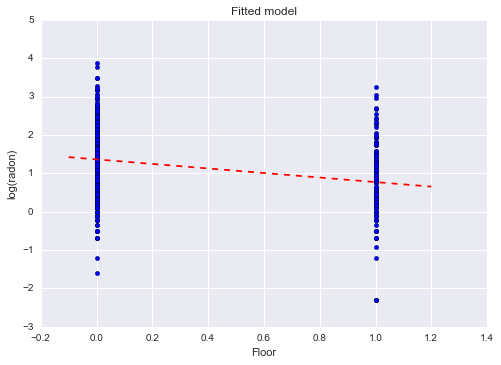

In [9]:
# Plot the fitted model (red line) against observed values (blue points)
plt.scatter(clean_data.srrs_mn.floor, np.log(clean_data.srrs_mn.activity + 0.1))
xvals = np.linspace(-0.1, 1.2)
plt.plot(xvals, m0 * xvals + b0, 'r--')
plt.title("Fitted model")
plt.xlabel("Floor")
plt.ylabel("log(radon)");

The answer is: not terribly badly (the fitted line runs convincingly through the centre of the data, and plausibly describes the trend), but not terribly well, either. The observed points vary widely about the fitted model, implying that the prevailing radon level varies quite widely, and we might expect different gradients if we chose different subsets of the data.

The main error in this model fit is due to *bias*, because the pooling approach is an an inaccurate representation of the underlying radon level, taken across all measurements.